In [1]:
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
ten

In [2]:
import os
import glob
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout


data = []

#Cargar los datos con OpenCv
paths = ["/kaggle/input/real-life-violence-situations/new_violence"]

#Mostrar imagen
def imshow(img):
    fig,ax = plt.subplots(1,1,figsize = (5,5))
    ax.imshow(img)
    plt.show()

#agregar las etiquetas de salida dadas las carpetas con su nombre
possible_labels = os.listdir(paths[0])
print(possible_labels)

print(f"TensorFlow Version: {tf.__version__}")

['non_violence', 'violence']
TensorFlow Version: 2.16.1


# Guardando los datos en el array data

In [3]:
for label_int, label_str in enumerate(possible_labels):
       for filename in glob.glob(os.path.join(paths[0],label_str, "*.jpg")):
            img = cv2.imread(filename.replace("\\", "/"))
            if img is not None:  # Verificar si la imagen se ha leído correctamente
                try:
                    resized_img = cv2.resize(img, (320, 320))
                    data.append([label_int, resized_img])
                except Exception as e:
                    print(f"Error resizing image {filename}: {e}")
            else:
                print(f"Warning: Unable to read image {filename} Please check the file path and format.")
print(len(data))

11073


# Insertando los datos (training, validacion y testing) en arrays de numpy 

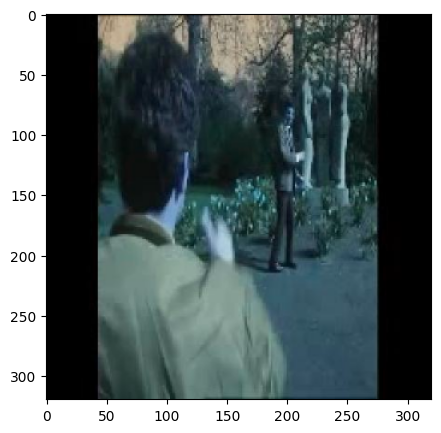

non_violence


In [4]:
#Se Barajea el arreglo data para que no inserte los datos por carpetas
random.Random(0).shuffle(data)

#Se crea arreglos para los conjuntos de validacion, tewsting y entrenamiento
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

#Se recorre la lista data para agregar las imagenes a sus correspondientes arreglos
for i,sample in enumerate(data):
    label= sample[0]
    img = sample[1]
    if i <= 0.8*len(data):
        x_train.append(img)
        y_train.append(label)
    elif i >0.8*len(data) and i <= 0.9*len(data):
        x_val.append(img)
        y_val.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

#Convirtiendo los arrays en arreglos de NumPy para Tensorflow
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

#Mostrar Imagen en la pos 0
imshow(x_train[0])
print(possible_labels[y_train[0]])

# Convirtiendo las labels de las imagenes en One-Hot Encoding

In [5]:
y_trainOneHot = tf.one_hot(y_train,len(possible_labels))
y_valOneHot = tf.one_hot(y_val,len(possible_labels))
y_testOneHot = tf.one_hot(y_test,len(possible_labels))
print("done")

done


# Definiendo el modelo 

In [6]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

def cnn_model():
    model = Sequential()
    model.add(Input(shape=(320, 320, 3)))
    model.add(Convolution2D(32, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(128, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(256, (3, 3), activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dense(len(possible_labels), activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
model = cnn_model()
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 318, 318, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 157, 157, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 76, 76, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 36, 36, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    42,467,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,993,090 (164.01 MB)

 Trainable params: 42,990,594 (164.00 MB)

 Non-trainable params: 2,496 (9.75 KB)

None


# Guardando el proceso automaticamente y configurando Tensorboard

In [8]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

log_dir = "logs/cnn_logs/train"
os.makedirs(log_dir, exist_ok=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq = 1)

print(x_train.shape)

(8859, 320, 320, 3)


# Entrenando el Modelo

In [9]:
model.fit(
    x_train,
    y_trainOneHot,
    epochs = 20,
    batch_size = 64,
    validation_data = (x_val, y_valOneHot),
    callbacks = [tensorboard_callback, checkpoint]
)

Epoch 1/20


I0000 00:00:1717430871.282125      82 service.cc:145] XLA service 0x7d1660006450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717430871.282219      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-06-03 16:07:53.933957: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,318,318]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,320,320]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-06-03 16:07:54.471345: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9337: 4.03405, expected

138/139 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7928 - loss: 2.8826

2024-06-03 16:08:25.628524: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 921: 5.8781, expected 5.16091
2024-06-03 16:08:25.628601: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2372: 5.67886, expected 4.96167
2024-06-03 16:08:25.628617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3295: 5.5146, expected 4.79741
2024-06-03 16:08:25.628626: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3337: 5.57453, expected 4.85734
2024-06-03 16:08:25.628639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4102: 6.15528, expected 5.43809
2024-06-03 16:08:25.628650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4520: 5.74603, expected 5.02884
2024-06-03 16:08:25.628662: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5207: 6.07665, expected 5.35947
2024-06-03 16:08:25.628675: E external/local

139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7931 - loss: 2.8805

I0000 00:00:1717430915.764131      80 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads

2024-06-03 16:08:38.811582: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505620: 8.34416, expected 7.39305
2024-06-03 16:08:38.811638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505621: 7.74864, expected 6.79753
2024-06-03 16:08:38.811649: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505622: 7.97717, expected 7.02606
2024-06-03 16:08:38.811658: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505623: 6.95818, expected 6.00707
2024-06-03 16:08:38.811666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505624: 7.82683, expected 6.87572
2024-06-03 16:08:38.811675: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 505


Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 63s 298ms/step - accuracy: 0.7935 - loss: 2.8783 - val_accuracy: 0.7850 - val_loss: 2.0510
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9081 - loss: 1.5442
Epoch 2: val_accuracy improved from 0.78500 to 0.83559, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 187ms/step - accuracy: 0.9081 - loss: 1.5432 - val_accuracy: 0.8356 - val_loss: 1.4072
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9212 - loss: 1.1352
Epoch 3: val_accuracy improved from 0.83559 to 0.86992, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 26s 185ms/step - accuracy: 0.9212 - loss: 1.1350 - val_accuracy: 0.8699 - val_loss: 1.0949
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9328 - loss: 0.9105
Epoch 4: val_accuracy improved from 0.86992 to 0.87895, saving model to best_model.keras
139/139 ━━━━━━━━━━━━━━

In [10]:
# Cargar el mejor modelo guardado
best_model = keras.models.load_model('best_model.keras')

# Prediccion

2024-06-03 16:17:27.044506: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 6.25329, expected 5.50563
2024-06-03 16:17:27.045980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 6.06822, expected 5.32056
2024-06-03 16:17:27.046001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 8: 5.58897, expected 4.84131
2024-06-03 16:17:27.046013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 9: 5.79339, expected 5.04572
2024-06-03 16:17:27.046026: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 10: 6.19196, expected 5.4443
2024-06-03 16:17:27.046037: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 18: 6.17255, expected 5.42489
2024-06-03 16:17:27.046049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 20: 6.11393, expected 5.36627
2024-06-03 16:17:27.046061: E external/local_xla/xla/service

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


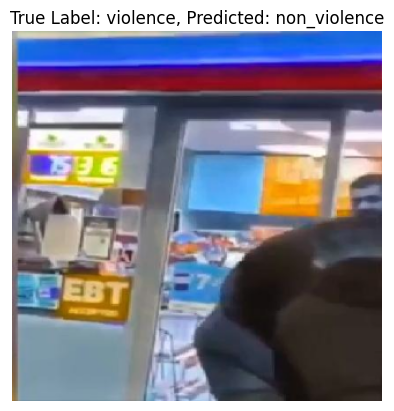

True Label: violence
Predicted Label: non_violence


In [11]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tus datos de prueba están almacenados en x_test y y_test
# Selecciona una imagen aleatoria del conjunto de datos de prueba
random_index = random.randint(0, len(x_test) - 1)
random_image = x_test[random_index]
true_label = y_test[random_index]

# Realiza la predicción
prediction = best_model.predict(random_image[np.newaxis, ...])
predicted_label = possible_labels[np.argmax(prediction)]

# Muestra la imagen junto con la etiqueta verdadera y la predicción
plt.imshow(random_image)
plt.title(f"True Label: {possible_labels[true_label]}, Predicted: {predicted_label}")
plt.axis('off')
plt.show()

print(f"True Label: {possible_labels[true_label]}")
print(f"Predicted Label: {predicted_label}")


In [12]:
best_model.save('modelViolenceNuevoVersion216.h5')

In [13]:
# Guarda la arquitectura del modelo en JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Guarda los pesos del modelo en HDF5
best_model.save_weights("model.weights.h5")


2024-06-03 16:17:34.458465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5499: 4.36668, expected 3.82808
2024-06-03 16:17:34.458585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 15506: 4.36668, expected 3.82808
2024-06-03 16:17:34.458663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 25511: 4.36668, expected 3.82808
2024-06-03 16:17:34.458745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 35518: 4.36668, expected 3.82808
2024-06-03 16:17:34.458853: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 45523: 4.36668, expected 3.82808
2024-06-03 16:17:34.458963: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 55530: 4.36668, expected 3.82808
2024-06-03 16:17:34.459065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 65535: 4.36668, expected 3.82808
2024-06-03 16:17:34.459188: E exter

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9188 - loss: 0.7470
Validation Accuracy: 0.91
Validation Loss: 0.86
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


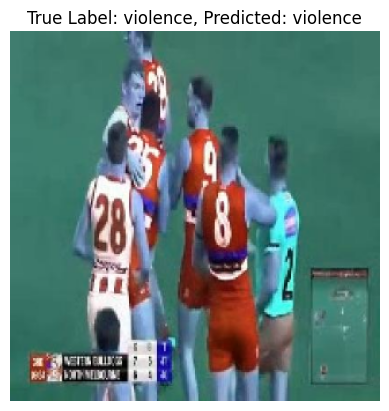

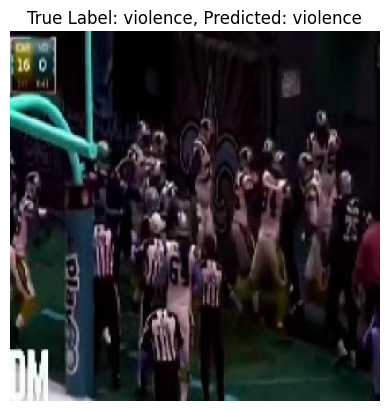

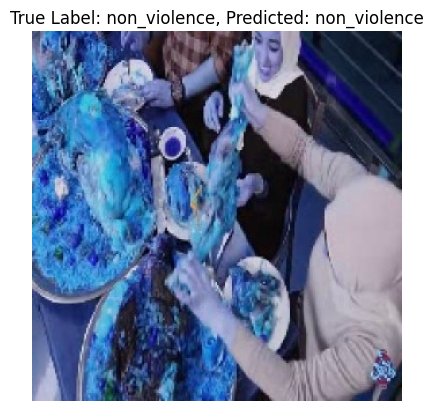

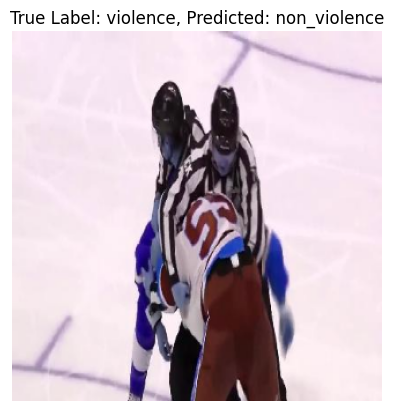

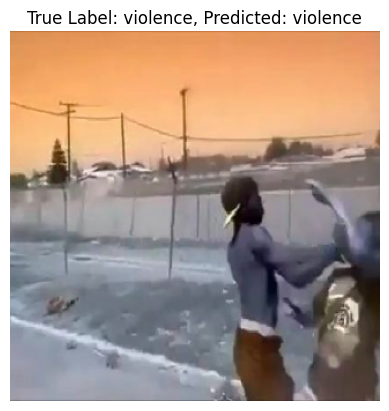

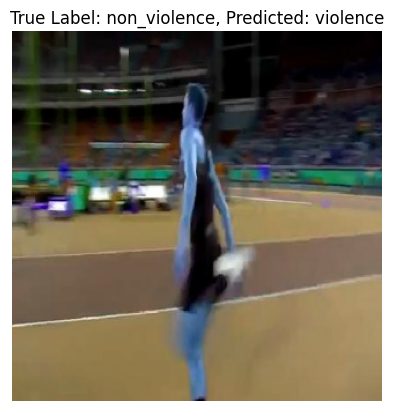

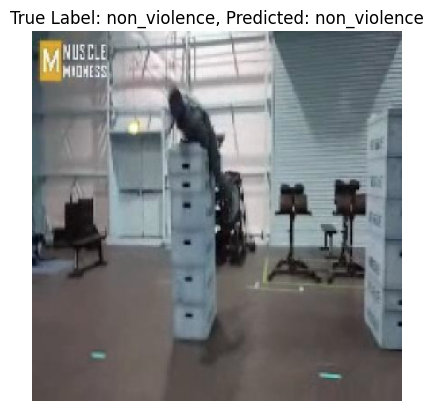

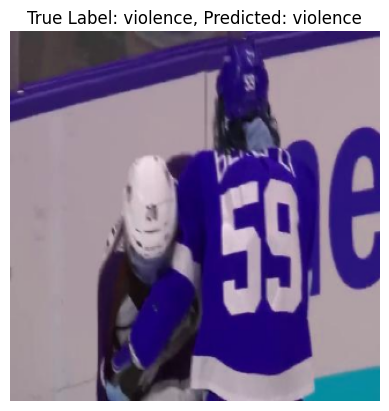

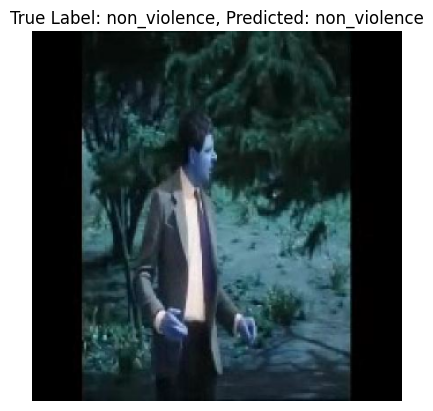

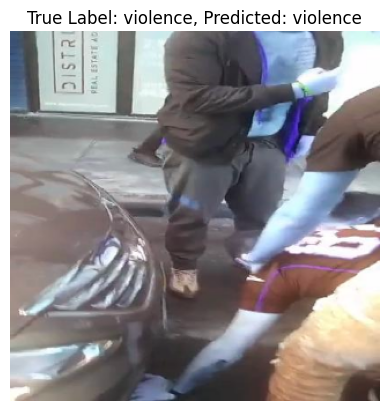

In [14]:
# Evaluar el modelo con datos de validación
val_loss, val_accuracy = best_model.evaluate(x_val, y_valOneHot)
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Validation Loss: {val_loss:.2f}')

# Hacer predicciones en el conjunto de datos de prueba
predictions = best_model.predict(x_test)

# Visualizar algunas predicciones
num_samples = 10
for _ in range(num_samples):
    # Seleccionar una imagen aleatoria del conjunto de datos de prueba
    random_index = random.randint(0, len(x_test) - 1)
    random_image = x_test[random_index]
    true_label = y_test[random_index]
    
    # Realizar la predicción
    prediction = predictions[random_index]
    predicted_label = np.argmax(prediction)
    
    # Mostrar la imagen junto con la etiqueta verdadera y la predicción
    plt.imshow(random_image)
    plt.title(f'True Label: {possible_labels[true_label]}, Predicted: {possible_labels[predicted_label]}')
    plt.axis('off')
    plt.show()
